In [1]:
"""
Mount Google Colab Notebook correctly so we are in the correct relative directory
"""
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"3. COVID_Forecaster"

Mounted at /content/gdrive
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/3. COVID_Forecaster


In [2]:
###################################################################################################################################
"""
Ensure we have correct version of Pytorch Geometric before importing or installing anything else
"""
# Code in this cell is courtesy of: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7 
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch
import os

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install torch-geometric-temporal # added for GConvGRU
!pip install ogb

print("PyTorch has version {}".format(torch.__version__))

########################################################################################################################################

"""
Download and Import any other libraries we will use later on
"""

! pip install epiweeks
! pip install haversine

import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch.nn import Linear
from torch_geometric.nn import GCNConv 
from torch_geometric_temporal.nn.recurrent import GConvGRU
# from preprocess_data import get_preprocessed_data

##############################################################################################################################################


Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 2.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 2.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.5 MB 2.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 750 kB 2.7 MB/s 
     |████████████████████████████████| 407 kB 5.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=65ae8c3df678fa282118dec4927d0f8a238a25fee10a16edf1a7141f3bf38c77
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 48 kB 2.3 MB/s 
  Created wheel for torch-geometric-temporal

In [3]:
"""
Declare global variables
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
inputLayer_num_features = 24
hiddenLayer1_num_features = 24
hiddenLayer2_num_features = 24
outputLayer_num_features = 15 # pred_window, redeclared from preprocessing_data
chebyshev_filter_size = 2
history_window = 6 # history_window, redeclared from preprocessing_data 
preprocessed_data_relative_file_path = 'data/preprocessed_data_v3.3_to_3.5_new_data.pickle'
save_model_relative_path = './saved_models/v3.3_new_data_COVID_Forecaster_full'
numEpochs = 1000
save_predictions_relative_path = './saved_models/v3.3_archived_output.pickle'

cpu


In [4]:
# Try to ensure reproducibility
torch.manual_seed(0)

In [ ]:
"""
Get and unpack preprocessed data
"""

# # Get preprocessed data and unpackage variables needed during training/testing/validation
# preprocessed_data = get_preprocessed_data()
# # Save preprocessed data as pickle so we don't have to consecutively re-download the same data (time consuming) when re-running all cells in this notebook
# with open(preprocessed_data_relative_file_path, 'wb') as handle:
#     pickle.dump(preprocessed_data, handle)


# Load in saved preprocessed_data
preprocessed_data = None
with open(preprocessed_data_relative_file_path, 'rb') as handle:
    preprocessed_data = pickle.load(handle)

# Unpack preprocessed data
training_variables = preprocessed_data['training_variables']
validation_variables = preprocessed_data['validation_variables']
testing_variables = preprocessed_data['testing_variables']

edge_index = preprocessed_data['edge_index']

train_x = training_variables['train_x_smoothed']
train_y = training_variables['train_y_confirmed_smoothed']

val_x = validation_variables['val_x_smoothed']
val_y = validation_variables['val_y_confirmed_unsmoothed']

test_x = testing_variables['test_x_smoothed']
test_y = testing_variables['test_y_confirmed_unsmoothed']

In [ ]:
"""
Put preprocessed data into "Data" objects and put "Data" objects into tensors on the "device"
"""
training_data = []
validation_data = []
testing_data = []
for i in range(len(train_x)):
  toAppend = Data(x=train_x[i], y=train_y[i], edge_index=edge_index).to(device)
  training_data.append(toAppend)
for i in range(len(val_x)):
  toAppend = Data(x=val_x[i], y=val_y[i], edge_index=edge_index).to(device)
  validation_data.append(toAppend)
for i in range(len(test_x)):
  toAppend = Data(x=test_x[i], y=test_y[i], edge_index=edge_index).to(device)
  testing_data.append(toAppend)

In [ ]:
"""
Define network architecture, optimizer, and loss function
Reference: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html 
"""

class COVID_Forecaster_full(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = GConvGRU(in_channels=inputLayer_num_features, out_channels=hiddenLayer1_num_features, K=chebyshev_filter_size)
      self.conv2 = GConvGRU(in_channels=hiddenLayer1_num_features, out_channels=hiddenLayer2_num_features, K=chebyshev_filter_size)
      self.linear1 = Linear(hiddenLayer2_num_features, outputLayer_num_features)
      self.linear2 = Linear(history_window, outputLayer_num_features)
      self.linear3 = Linear(outputLayer_num_features, outputLayer_num_features)

    def forward(self, data):
      x, edge_index = data.x, data.edge_index
      x = self.conv1(x, edge_index)
      x = F.elu(x)
      x = self.conv2(x, edge_index)
      x = F.elu(x)
      x = self.linear1(x) + self.linear2(data.x[:, 0:history_window])

      x = F.elu(x)
      x = self.linear3(x)

      return x

model = COVID_Forecaster_full().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.MSELoss()

In [ ]:
model

COVID_Forecaster_full(
  (conv1): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (conv2): GConvGRU(
    (conv_x_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_z): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_r): ChebConv(24, 24, K=2, normalization=sym)
    (conv_x_h): ChebConv(24, 24, K=2, normalization=sym)
    (conv_h_h): ChebConv(24, 24, K=2, normalization=sym)
  )
  (linear1): Linear(in_features=24, out_features=15, bias=True)
  (linear2): Linear(in_features=6, out_features=15, bias=True)
  (linear3): Linear(in_features=15, out_features=15, bias=True)
)

In [ ]:
"""
Training
"""
min_loss = 1e20

def train():
  total_loss = 0.0
  for data in training_data:
    model.train()
    optimizer.zero_grad()
    predicted_output = model(data)
    labeled_output = data.y.to(device)
    loss = criterion(predicted_output, labeled_output)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
  return total_loss

def validation():
  model.eval()
  totalLoss = 0.0
  for data_validation in validation_data:
    validation_prediction_output = model(data_validation)
    labeled_validation_output = data_validation.y.to(device)
    loss = criterion(validation_prediction_output, labeled_validation_output)
    totalLoss += loss.item()
  return totalLoss

for epoch in range(numEpochs):
  training_loss = train()
  val_loss = validation()
  if val_loss < min_loss:
    min_loss = val_loss
    state = {
        'state': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, save_model_relative_path)
    print("==================================================================")
    print("Saved best model")
  print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, training_loss, val_loss))

Saved best model
Epoch 0, Loss 93805565402.00, Val loss 32237856768.00
Saved best model
Epoch 1, Loss 47085821279.00, Val loss 29494781952.00
Saved best model
Epoch 2, Loss 44221056994.00, Val loss 27942463488.00
Epoch 3, Loss 42833796073.50, Val loss 47243345920.00
Epoch 4, Loss 52687074589.00, Val loss 43452399616.00
Epoch 5, Loss 59187599032.00, Val loss 57806032896.00
Epoch 6, Loss 110120048002.00, Val loss 35676921856.00
Epoch 7, Loss 50627872581.00, Val loss 34854072320.00
Epoch 8, Loss 49680058274.00, Val loss 30570014720.00
Epoch 9, Loss 47445732286.00, Val loss 32907759616.00
Epoch 10, Loss 49833828576.00, Val loss 33465399296.00
Epoch 11, Loss 52360711394.00, Val loss 52271767552.00
Epoch 12, Loss 66014063812.00, Val loss 64293470208.00
Epoch 13, Loss 77897301972.00, Val loss 58954100736.00
Epoch 14, Loss 73408043170.00, Val loss 61619994624.00
Epoch 15, Loss 76727463360.00, Val loss 56417538048.00
Epoch 16, Loss 72488775172.00, Val loss 60576153600.00
Epoch 17, Loss 77181844

11941960704.0
tensor([304631.8125, 305597.7188, 306572.0625, 307513.5312, 308292.1562,
        308696.3125, 308879.8750, 309931.6562, 311487.1875, 312880.6250,
        313507.8750, 313894.5312, 314994.3750, 316399.2500, 317805.2812],
       grad_fn=<SelectBackward0>)
tensor([292187., 293697., 293697., 293697., 293697., 293697., 295701., 296870.,
        297729., 297729., 297729., 298362., 298626., 298808., 298993.])


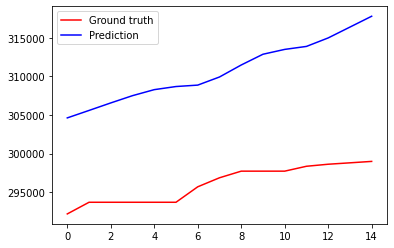

In [ ]:
"""
Testing and plotting results
"""

predicted_output = None
labeled_output = None
for data in testing_data:
  model.eval()
  predicted_output = model(data)
  labeled_output = data.y.to(device)
  loss = criterion(predicted_output, labeled_output)
  print(loss.item())

state_num = 29

print(predicted_output[state_num])
print(labeled_output[state_num])

plt.plot(labeled_output[state_num].cpu().detach().numpy(),c='r', label='Ground truth')
plt.plot(predicted_output[state_num].cpu().detach().numpy(),c='b', label='Prediction')
plt.legend()
plt.show()

In [ ]:
archived_output = {
    # 'loc_list':loc_list, 
    # 'model_predictions_number_infected_dictionary':model_predictions_number_infected_dictionary, 
    'model_predictions_cumulative_infected_tensor':predicted_output, # (52, 15)
    # 'ground_truth_number_infected_dictionary':ground_truth_number_infected_dictionary, 
    'ground_truth_cumulative_infected_tensor':labeled_output # (52, 15)
}

# Save archived_output as pickle for use later
with open(save_predictions_relative_path, 'wb') as handle:
    pickle.dump(archived_output, handle)


# # Load in archived_output pickle
# archived_output = None
# with open(save_predictions_relative_path, 'rb') as handle:
#     archived_output = pickle.load(handle)

In [14]:
# Save archived_output as a CSV file
archived_output = None
with open(save_predictions_relative_path, 'rb') as handle:
  archived_output = pickle.load(handle)
model_predictions = archived_output['model_predictions_cumulative_infected_tensor']

state_list = None
state_name_to_abbrev = None
with open('data/preprocessed_data_v3.3_to_3.5_new_data.pickle', 'rb') as handle:
  preprocessed_data = pickle.load(handle)
  state_list = preprocessed_data['state_list']
  state_name_to_abbrev = preprocessed_data['state_name_to_abbrev']

date_list = ['2022-02-17', '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21', 
             '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-26', 
             '2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03']

import csv
with open('data/saved_output_v3.3_new_data_COVID_Forecaster_full.csv', 'w') as handle:
  csv_writer = csv.writer(handle)
  csv_writer.writerow(['cumulative_cases', 'date_today', 'state'])
  for i, state_name in enumerate(state_list):
    state_predictions = model_predictions[i]
    curr_state_abbrev = state_name_to_abbrev[state_name]
    for j in range(len(state_predictions)):
      curr_day_prediction = state_predictions[j].item()
      curr_day = date_list[j]
      csv_writer.writerow([curr_day_prediction, curr_day, curr_state_abbrev])

In [ ]:
mean_squared_error = criterion(predicted_output.reshape((52, 15)), labeled_output.reshape((52, 15))).item()
mae_function = torch.nn.L1Loss()
mean_absolute_error = mae_function(predicted_output.reshape((52, 15)), labeled_output.reshape((52, 15))).item()
print("mean squared error: ", mean_squared_error)
print("mean absolute error: ", mean_absolute_error)
# Without seed: 
# mean squared error:  38665711616.0
# mean absolute error:  128769.2890625

# With seed = 0 - trial 1
# mean squared error:  11941960704.0
# mean absolute error:  70670.78125

# With seed = 0 - trial 2
# mean squared error:  11941960704.0
# mean absolute error:  70670.78125

mean squared error:  11941960704.0
mean absolute error:  70670.78125
